In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/utils/plotUtils/histogram.py:109: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if scale is 'xs': scale = scale/lumi


In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
signal = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450), Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_700_MY_300)])
bkg = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])

In [4]:
for sig in signal: sig.color=None

In [5]:
varinfo.clear()

  0%|          | 0/2 [00:00<?, ?it/s]

(62904,) (62904,)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
 50%|█████     | 1/2 [00:06<00:06,  6.36s/it]

(44979,) (44979,)
(62904,) (62904,)
(44979,) (44979,)


100%|██████████| 2/2 [00:06<00:00,  3.26s/it]


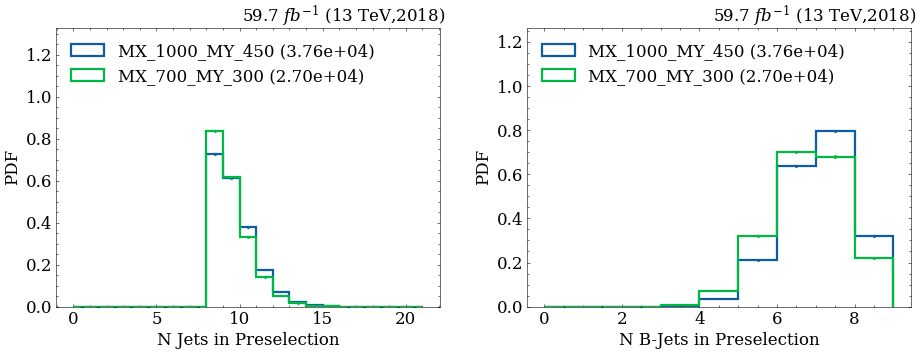

In [6]:
study.quick(
  signal, stacked=True, density=True, legend=True,
  varlist=['n_jet','nfound_presel'],
  xlabels=['N Jets in Preselection','N B-Jets in Preselection'],
  saveas='n_bjets'
)

In [7]:
# all_eightb = EventFilter("eightb", nfound_presel=8)
# filter_eightb = CollectionFilter("jet",filter=lambda t:t.jet_signalId>-1)
t8btag = CollectionFilter('jet', filter=lambda t: ( ak.argsort(ak.argsort(-t.jet_btag,axis=-1)) < 8 ) )

signal = signal.apply(t8btag)
bkg = bkg.apply(t8btag)


In [8]:
(signal+bkg).apply( eightb.build_all_ys )

[None, None, None]

In [9]:
def true_ys(tree):
  mask = (tree.y1_signalId>0)&(tree.y2_signalId>0)
  return mask
def fake_ys(tree):
  return ~true_ys(tree)

In [10]:
class filter_y(ObjTransform):
  def __call__(self, tree):
    yarg = self.select_y(tree)
    selected = [ get_collection(tree, obj.lower())[yarg][:,0] for obj in eightb.ylist+eightb.higgslist ]
    copy = tree.copy()
    copy.extend(*selected)
    return copy

class filter_h(filter_y):
  def __call__(self, tree):
    tree = super().__call__(tree)
    hy1arg = self.select_h(tree, y='y1')
    hy2arg = self.select_h(tree, y='y2')

    hy1 = [ get_collection(tree, h)[hy1arg][:,0] for h in ('h1y1','h2y1') ]
    hy2 = [ get_collection(tree, h)[hy2arg][:,0] for h in ('h1y2','h2y2') ]
    tree.extend(*hy1, *hy2)
    return tree

In [11]:
def y_ht(tree):
  return (tree.y1_pt + tree.y2_pt)

def ym_asym(tree):
  y1m = tree.y1_m
  y2m = tree.y2_m
  return np.abs(y1m-y2m)/(y1m+y2m)

def ypt_asym(tree):
  return np.abs(tree.y1_m-tree.y2_m)/(tree.y1_pt+tree.y2_pt)

def y_dphi(tree):
  dphi = calc_dphi(tree.y1_phi, tree.y2_phi)
  return np.cos(dphi/2)

def ytest(tree):
  asym = np.abs(tree.y1_m-tree.y2_m)/(tree.y1_pt+tree.y2_pt)
  return asym


100%|██████████| 1/1 [00:06<00:00,  6.57s/it]


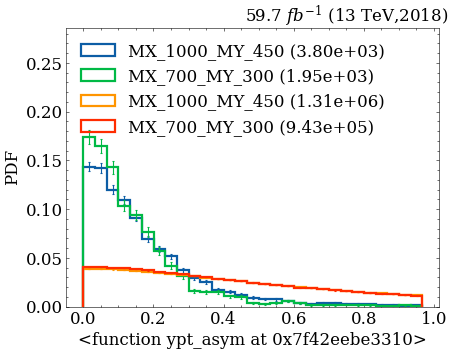

In [15]:
study.quick(
  signal+signal, legend=True,
  masks=[true_ys]*2+[fake_ys]*2,
  varlist=[ypt_asym],
  efficiency=True,
)

(<Figure size 468x468 with 1 Axes>, <AxesSubplot:>)

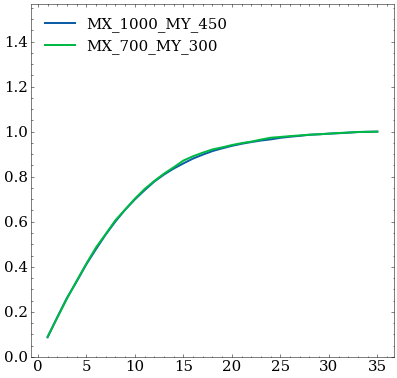

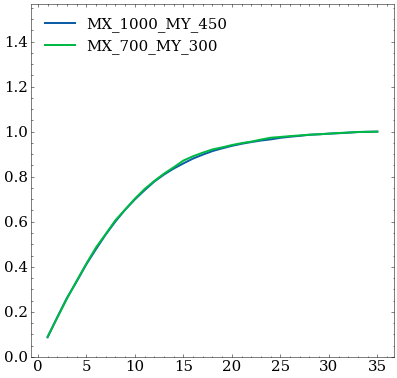

In [98]:
class hits_at_k(ObjTransform):
  def __call__(self, tree):
    mask = true_ys(tree)
    yvar = self.yvar(tree)
    skim = ak.any(mask, axis=-1)

    mask = mask[skim]
    yvar = yvar[skim]

    argsort = ak.argsort( yvar, axis=-1, ascending=self.ascending)
    mask = ak.to_numpy(mask[argsort])
    cumsum = np.cumsum(mask, axis=-1)
    hitsk = np.mean(cumsum, axis=0)
    arange = np.arange(hitsk.shape[0])+1
    return Graph(arange, hitsk, label=tree.sample)

plot_graphs(signal.apply(hits_at_k(yvar=ypt_asym, ascending=True)), legend=True)
plot_graphs(signal.apply(hits_at_k(yvar=ytest, ascending=True)), legend=True)


(<Figure size 468x468 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

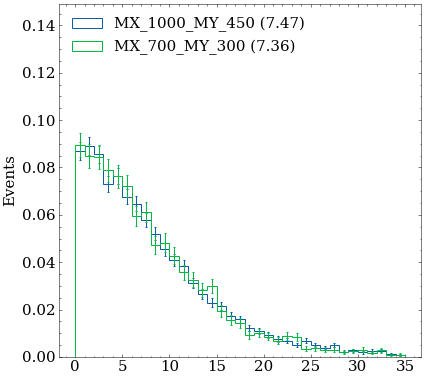

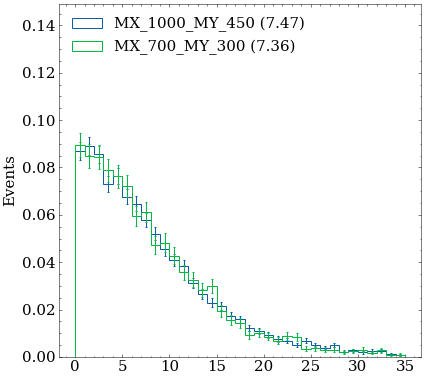

In [99]:

class true_rank(ObjTransform):
  def __call__(self, tree):
    mask = true_ys(tree)
    yvar = self.yvar(tree)
    skim = ak.any(mask, axis=-1)

    mask = mask[skim]
    yvar = yvar[skim]

    rank = ak.argsort(ak.argsort( yvar, axis=-1, ascending=self.ascending), axis=-1)
    rank = rank[mask]
    return Histo(rank, weights=tree.scale[skim], histtype='step', label=tree.sample, label_stat='{stats.mean:0.2f}', efficiency=True, )
    
plot_histos(signal.apply(true_rank(yvar=ypt_asym, ascending=True)), legend=True)
plot_histos(signal.apply(true_rank(yvar=ytest, ascending=True)), legend=True)
    

In [12]:
class ratio(ObjTransform):
  def __init__(self, n, d):
    super().__init__(n=n, d=d)
  def init(self):
    self.xlabel = f'{self.n}/{self.d}'
  def __call__(self, t):
    return t[self.n]/t[self.d]

In [100]:
def select_y(tree): 
  y_ht = tree.y1_pt + tree.y2_pt
  y_dm = np.abs(tree.y1_m  - tree.y2_m)

  yvar = y_dm / y_ht
  return ak.argmin( yvar, axis=-1, keepdims=True)
  
def select_h(tree, y='y1'):
  h1 = tree[f'h1{y}_pt']
  h2 = tree[f'h2{y}_pt']
  # hm_asym = (h1m - h2m)/np.sqrt(h1m**2 + h2m**2)
  var = h1 + h2
  return ak.argmax(var, axis=-1, keepdims=True)

# treesel = (signal+bkg).apply(filter_y(select_y=select_y, select_h=select_h))
treesel = (signal+bkg).apply(filter_y(select_y=select_y, select_h=select_h))

100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


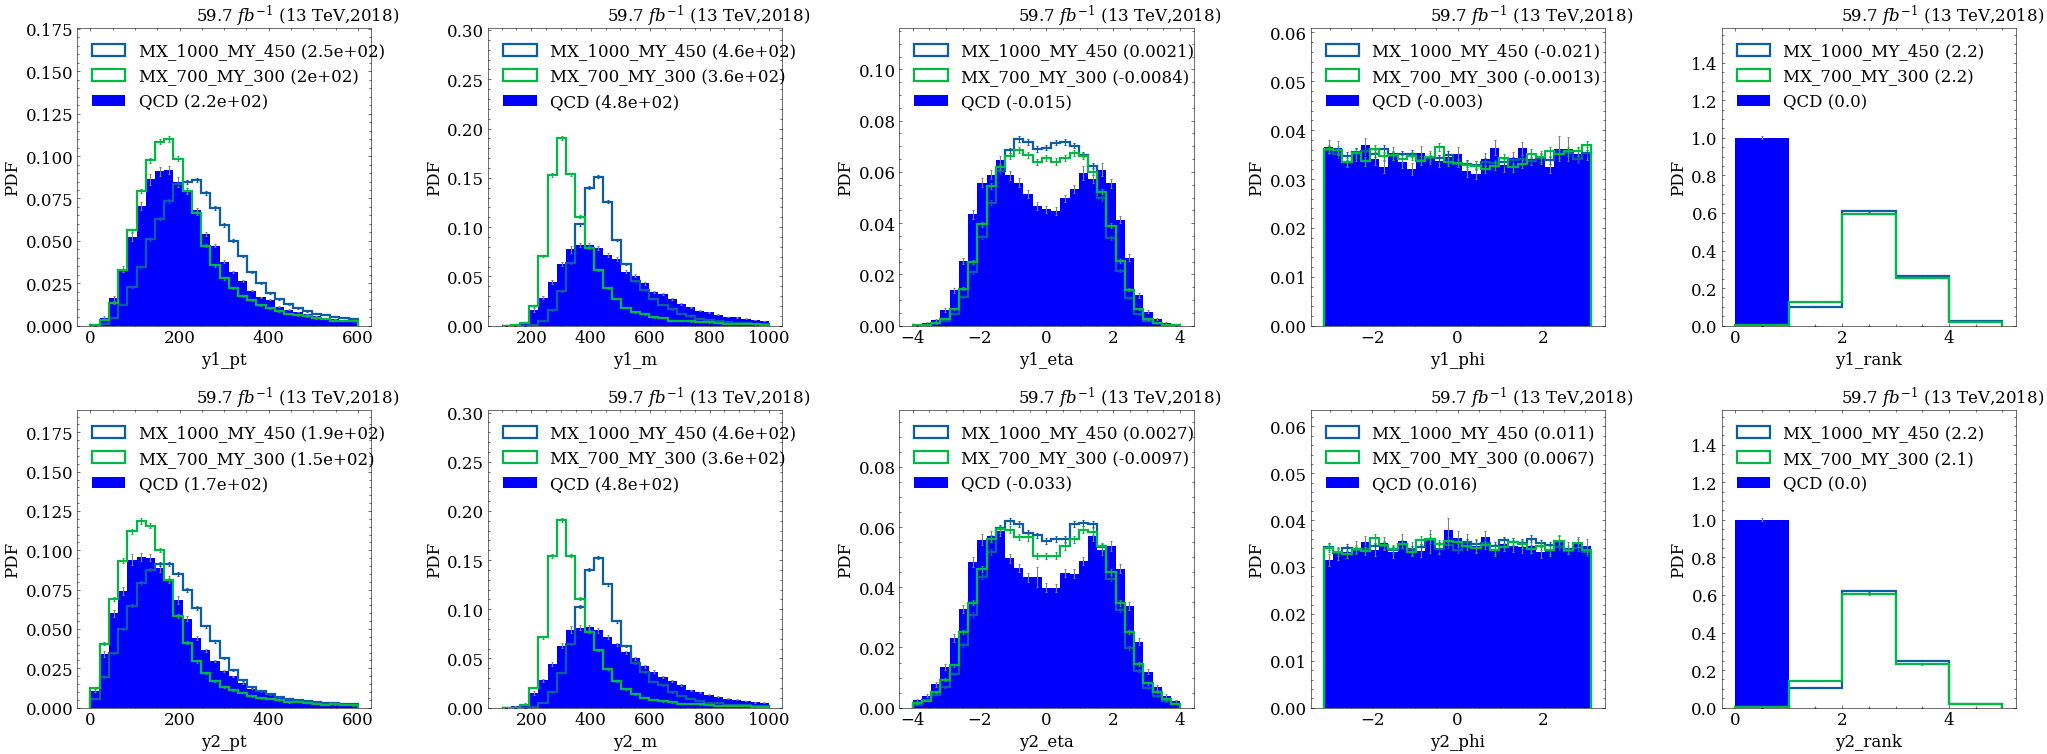

In [102]:
y_binlist = [(0,600,30),(100,1000,30),(-4,4,30),(-3.14,3.14,30),np.arange(6)]*2

study.quick(
  treesel, stacked=True, legend=True,
  varlist=[f'{obj.lower()}_{var}' for obj in eightb.ylist for var in ('pt','m','eta','phi','rank')],
  binlist=y_binlist,
  h_label_stat='{stats.mean:0.2}',
  dim=(-1,5),
  efficiency=True,
)

100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


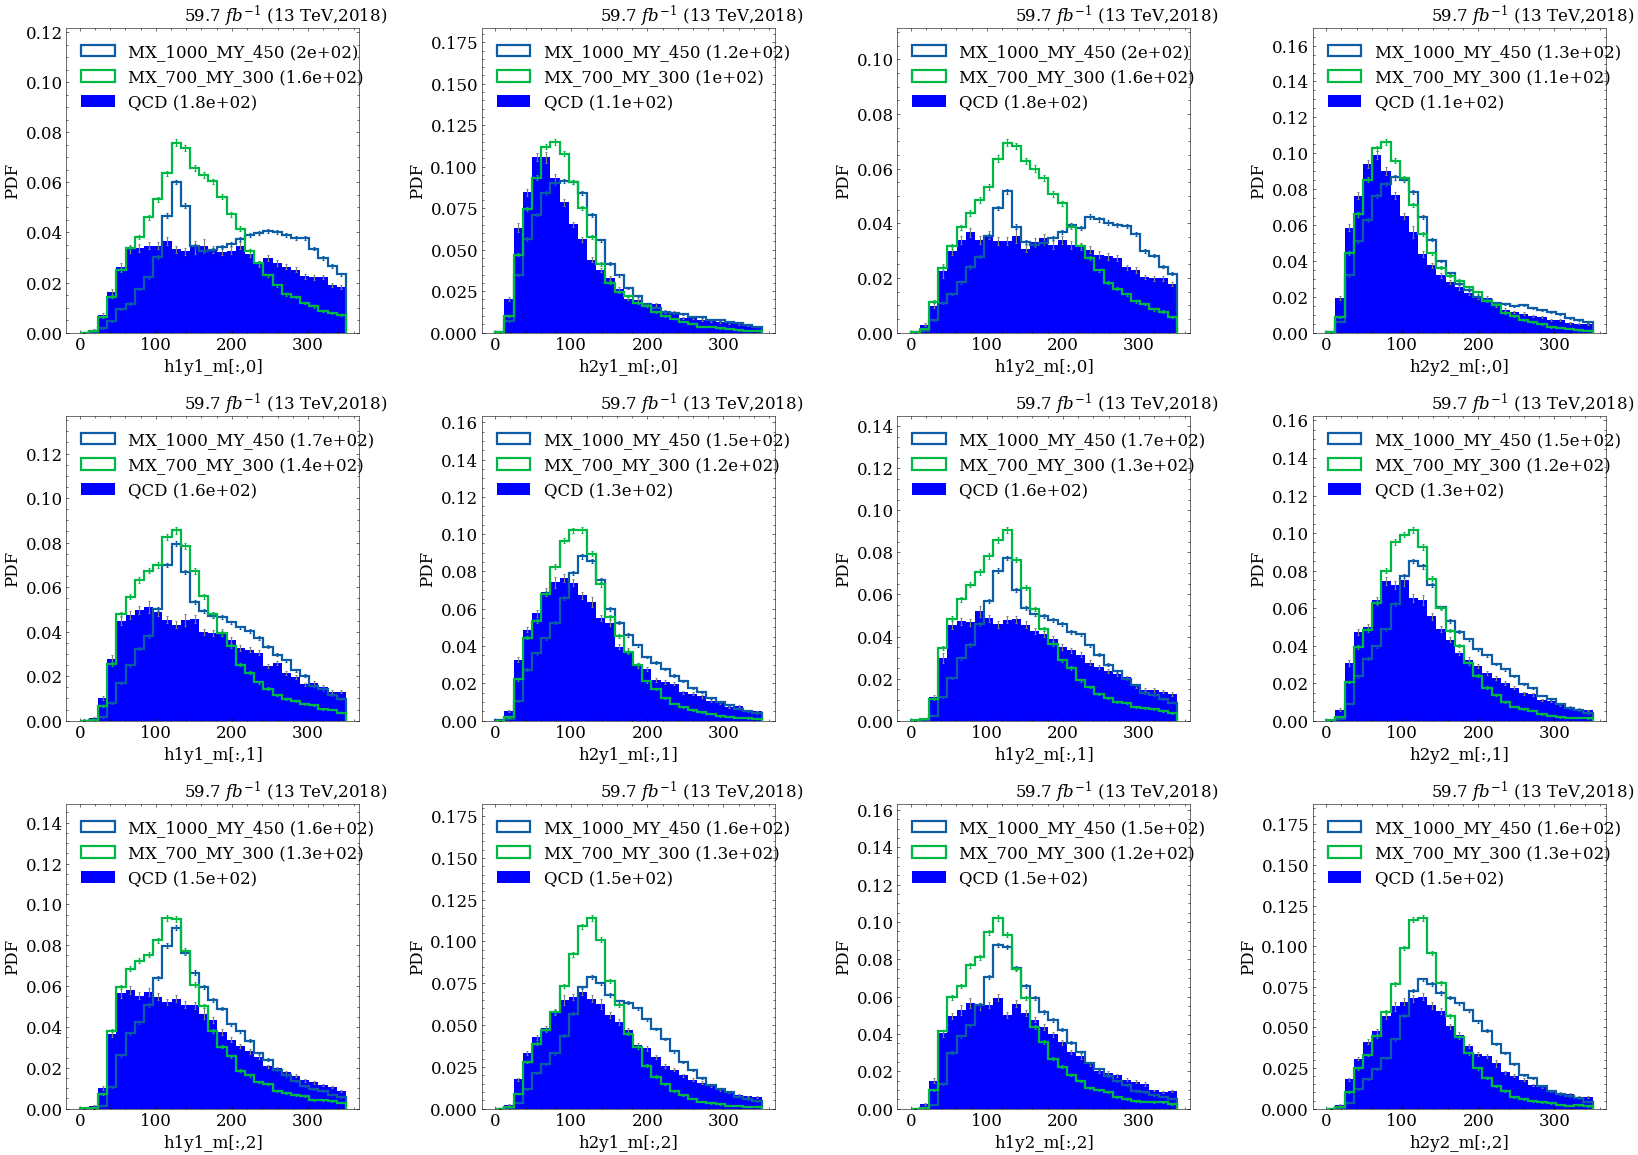

In [110]:
h_binlist = [(0,600,30),(0,350,30),(-4,4,30),(-3.14,3.14,30),np.arange(4)]*4

study.quick(
  treesel, stacked=True, legend=True,
  varlist=[f'{obj.lower()}_{var}[:,{i}]' for i in range(3) for obj in eightb.higgslist for var in ('m') ],
  binlist=[(0,350,30)]*12,
  dim=(-1,4),
  # binlist=h_binlist,
  h_label_stat='{stats.mean:0.2}',
  efficiency=True,
)

In [121]:
def select_y(tree): 
  y_ht = tree.y1_pt + tree.y2_pt
  y_dm = np.abs(tree.y1_m  - tree.y2_m)

  hy1_ht = tree.h1y1_pt + tree.h2y1_pt
  hy1_dm = np.abs(tree.h1y1_m - tree.h2y1_m)
  hy1var = ak.min(hy1_dm / hy1_ht, axis=-1)

  hy2_ht = tree.h1y2_pt + tree.h2y2_pt
  hy2_dm = np.abs(tree.h1y2_m - tree.h2y2_m)
  hy2var = ak.min(hy2_dm / hy2_ht, axis=-1)

  yvar = y_dm / y_ht
  return ak.argmin( yvar**2 + hy1var**2 + hy2var**2 , axis=-1, keepdims=True)
  
def select_h(tree, y='y1'):
  h1_pt, h1_m = tree[f'h1{y}_pt'], tree[f'h1{y}_m']
  h2_pt, h2_m = tree[f'h2{y}_pt'], tree[f'h2{y}_m']
  # hm_asym = (h1m - h2m)/np.sqrt(h1m**2 + h2m**2)
  ht = h1_pt + h2_pt
  dm = np.abs(h1_m - h2_m)
  return ak.argmin( dm/ht, axis=-1, keepdims=True)

# treesel = (signal+bkg).apply(filter_y(select_y=select_y, select_h=select_h))
treesel = (signal+bkg).apply(filter_h(select_y=select_y, select_h=select_h))

100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


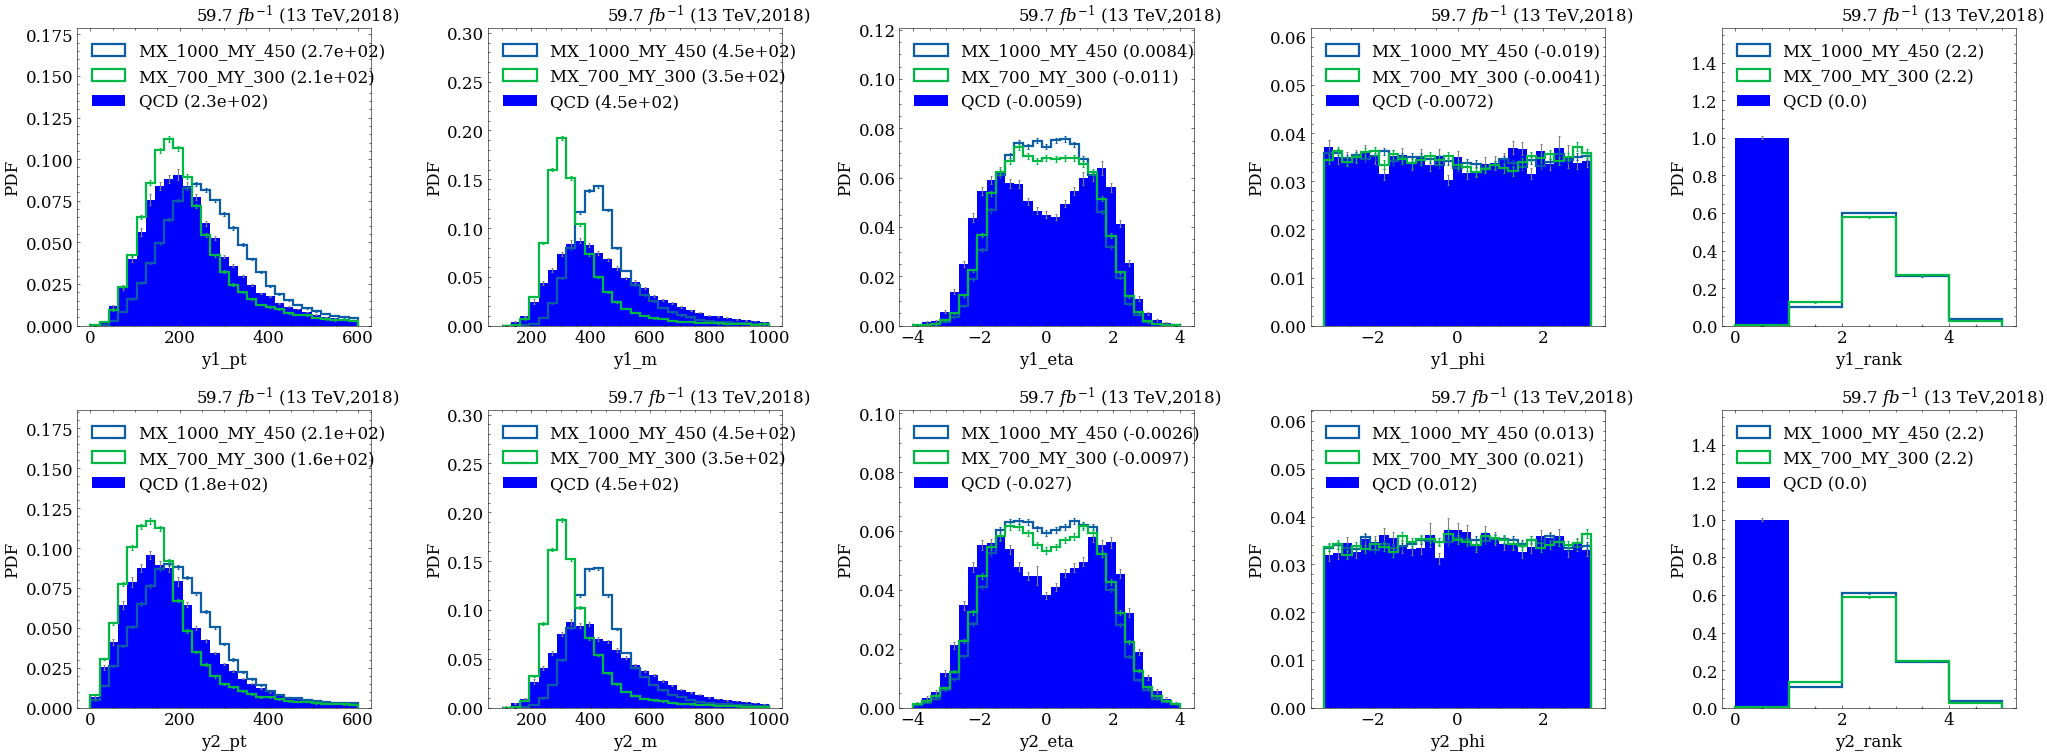

In [122]:
y_binlist = [(0,600,30),(100,1000,30),(-4,4,30),(-3.14,3.14,30),np.arange(6)]*2

study.quick(
  treesel, stacked=True, legend=True,
  varlist=[f'{obj.lower()}_{var}' for obj in eightb.ylist for var in ('pt','m','eta','phi','rank')],
  binlist=y_binlist,
  h_label_stat='{stats.mean:0.2}',
  dim=(-1,5),
  efficiency=True,
)

100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


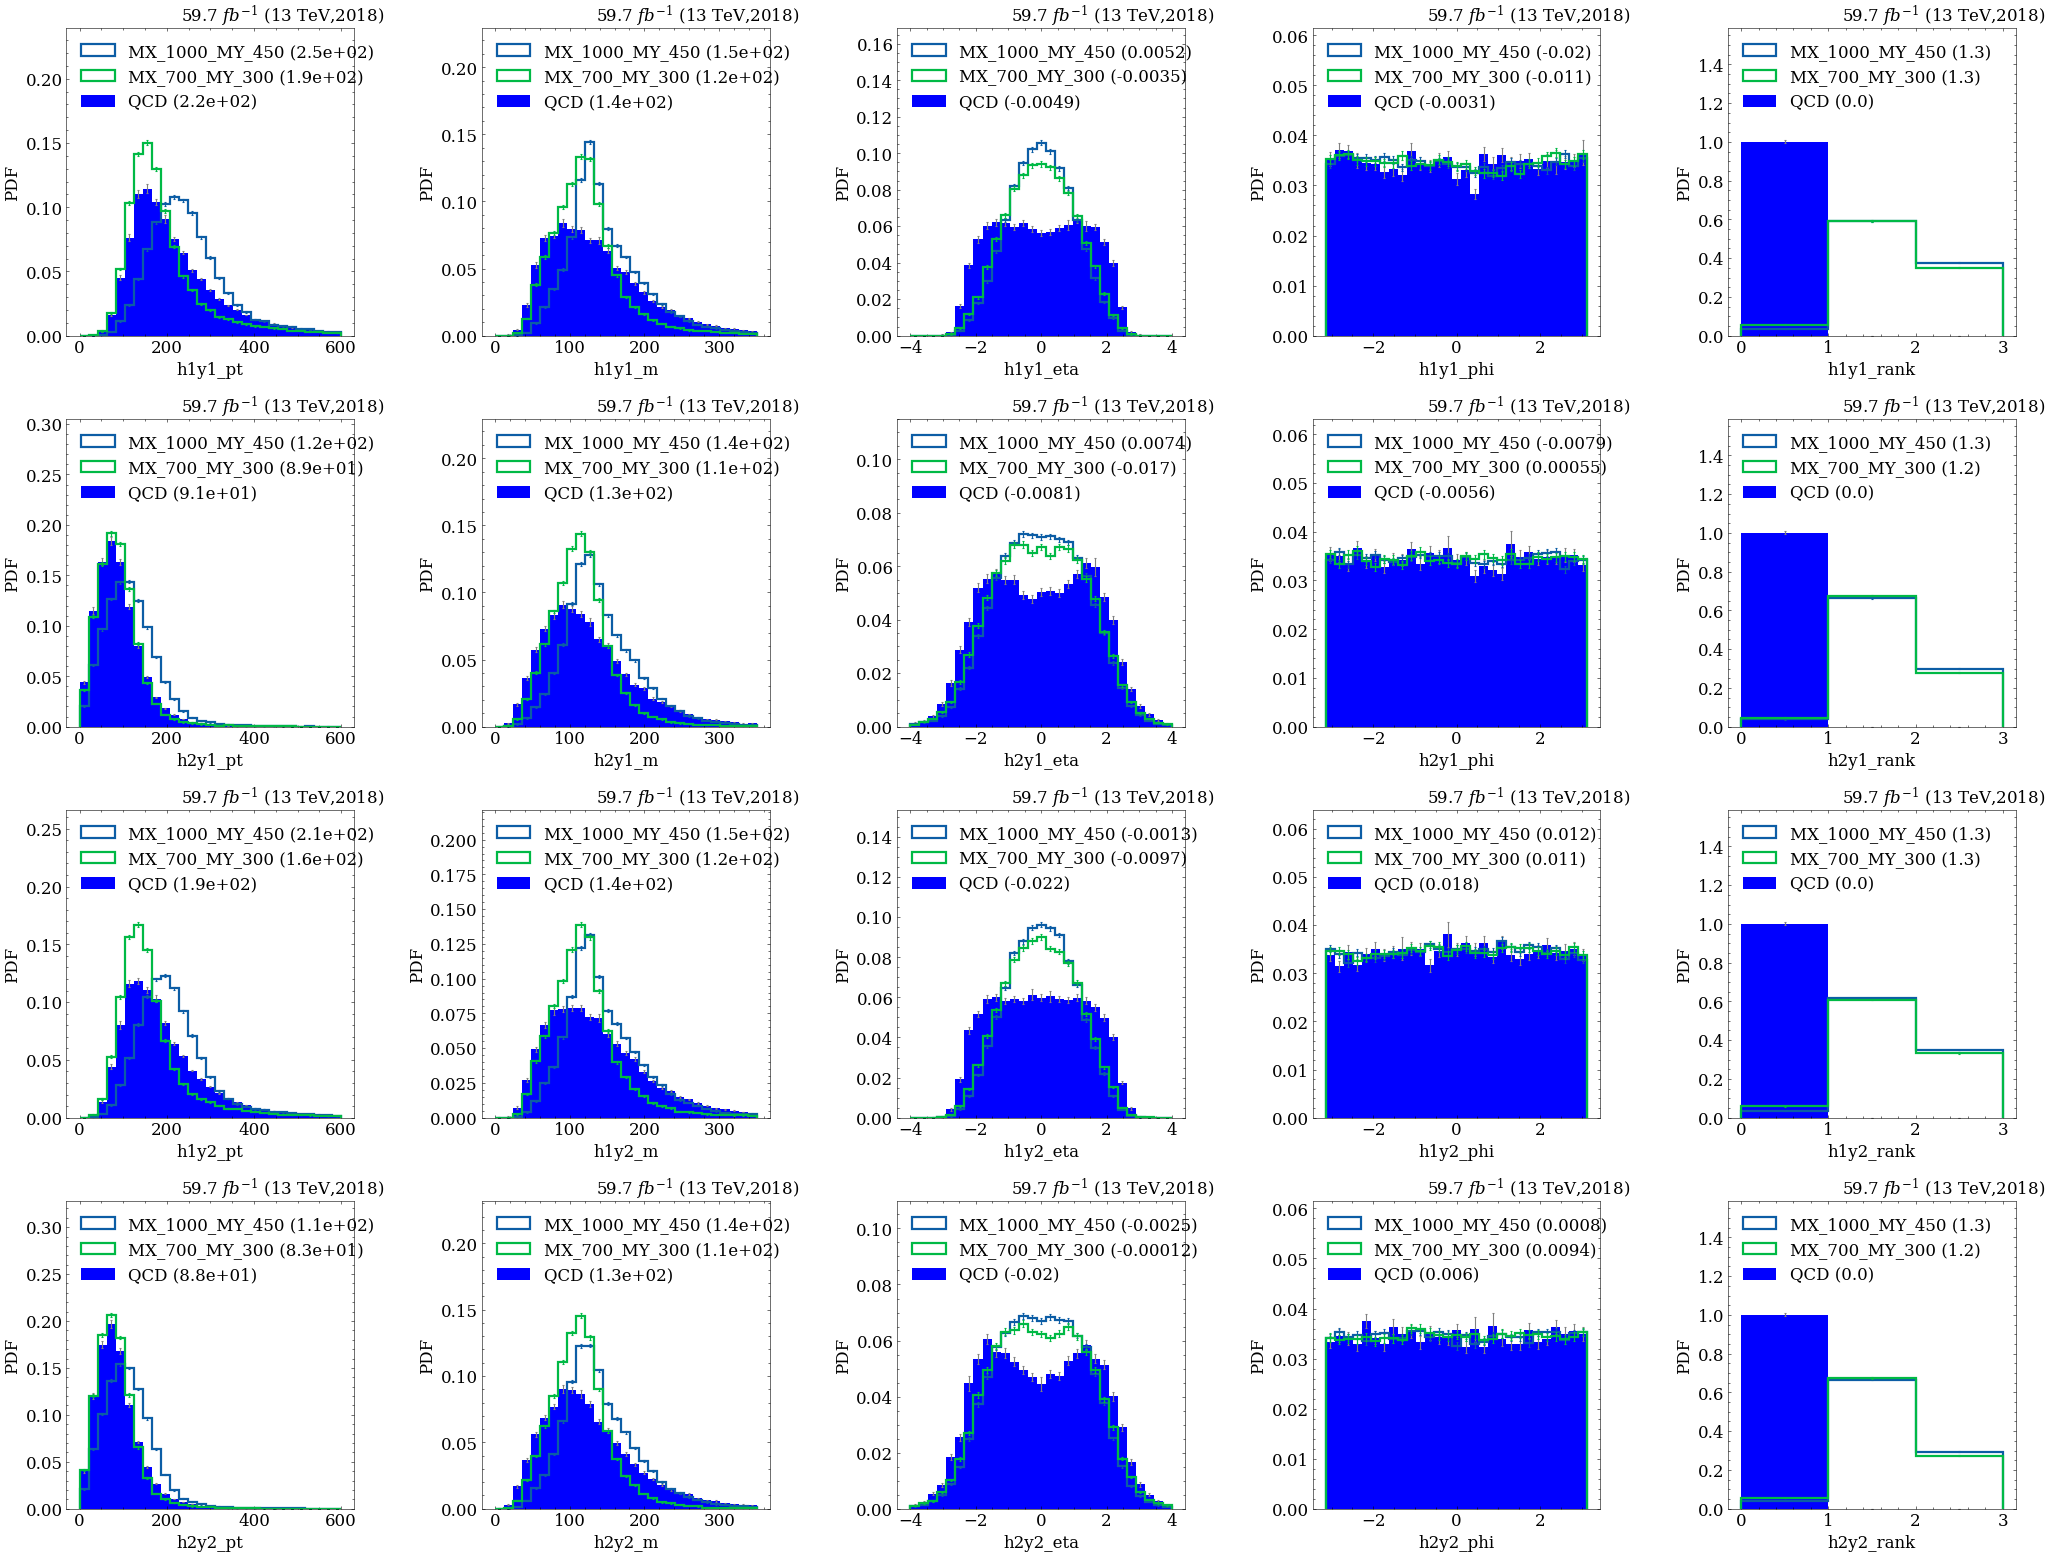

In [165]:
h_binlist = [(0,600,30),(0,350,30),(-4,4,30),(-3.14,3.14,30),np.arange(4)]*4

study.quick(
  treesel, stacked=True, legend=True,
  varlist=[f'{obj.lower()}_{var}' for obj in eightb.higgslist for var in ('pt','m','eta','phi','rank')],
  binlist=h_binlist,
  dim=(-1,5),
  # binlist=h_binlist,
  h_label_stat='{stats.mean:0.2}',
  efficiency=True,
)